# 수강생분의 이름, 학번을 반영해주세요.

In [1]:
id = '20197132'
name = '주준하'
print(id, name)

20197132 주준하


GPU 정보 확인

In [2]:
!nvidia-smi

Thu Apr 14 07:20:55 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

구글 드라이브 연동

In [3]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [4]:
import os
import sys

workspace_path = '/gdrive/My Drive/Colab Notebooks/CV_과제7'  # 실습파일 저장 경로 설정
cutblur_path = os.path.join(workspace_path, 'CutBlur')  # CutBlur 데이터 폴더 경로 설정
sys.path.append(cutblur_path)

# 코드자료 링크: https://github.com/clovaai/cutblur
## HR inputting demo
In this notebook, we visualize how the mixture of augmentation (MoA) and CutBlur prevent the SR model from over-sharpening when we provide an HR image as input. We compare the EDSR with MoA and without MoA (baseline).<br>

**Note:** This is a reproduced code for Figures 2 and 3 of the paper.<br>
However, results may differ (especially baseline) since the result of this code is derived using the final baseline (w/ X2 pre-train strategy) while the baseline model used in the paper was not.

In [5]:
"""
CutBlur
Copyright 2020-present NAVER corp.
MIT license
"""
import importlib
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import model.edsr as edsr
%matplotlib inline

# options for EDSR
class Opt:
    scale = 4
    num_blocks = 32
    num_channels = 256
    res_scale = 0.1

def im2tensor(im):
    np_t = np.ascontiguousarray(im.transpose((2, 0, 1)))
    tensor = torch.from_numpy(np_t).float()
    return tensor

def tensor2im(tensor):
    tensor = tensor.detach().squeeze(0)
    im = tensor.clamp(0, 255).round().cpu().byte().permute(1, 2, 0).numpy()
    return im

opt = Opt()
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")

net_base = edsr.Net(opt).to(dev)
net_moa = edsr.Net(opt).to(dev)

### HR inputting on the RealSR dataset

In [6]:
path_image = os.path.join(cutblur_path, "example/inputs/Nikon_006_HR.png")
path_base = os.path.join(cutblur_path, "pretrained/RealSR_EDSR_X4_base.pt")
path_moa = os.path.join(cutblur_path, "pretrained/RealSR_EDSR_X4_moa.pt")

state_base = torch.load(path_base, map_location=lambda storage, loc: storage)  # 학습된 모델 로드
state_moa = torch.load(path_moa, map_location=lambda storage, loc: storage)
net_base.load_state_dict(state_base)  # 모델 정보 반영
net_moa.load_state_dict(state_moa)

LR = io.imread(path_image)
LR_tensor = im2tensor(LR).unsqueeze(0).to(dev)

with torch.no_grad():
    SR_base = tensor2im(net_base(LR_tensor))
    SR_moa = tensor2im(net_moa(LR_tensor))

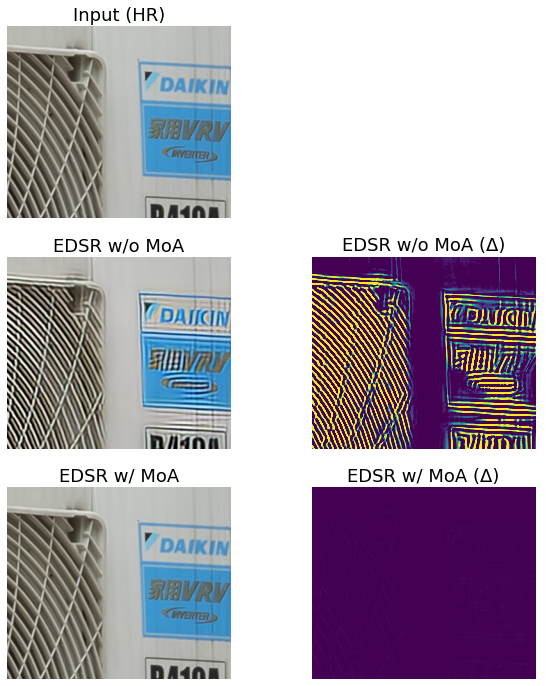

In [7]:
LR_plot = LR[100:400, 750:1100] / 255
SR_base_plot = SR_base[100:400, 750:1100] / 255
SR_moa_plot = SR_moa[100:400, 750:1100] / 255

diff_SR_base = (LR_plot-SR_base_plot).mean(2) * 10
diff_SR_moa = (LR_plot-SR_moa_plot).mean(2) * 10

f, axarr = plt.subplots(3, 2, figsize=(10, 12))
axarr[0, 0].imshow(LR_plot)
axarr[0, 0].set_title("Input (HR)", fontsize=18)
axarr[0, 0].axis("off")
 
axarr[0, 1].axis("off")
 
axarr[1, 0].imshow(SR_base_plot)
axarr[1, 0].set_title("EDSR w/o MoA", fontsize=18)
axarr[1, 0].axis("off")
 
axarr[1, 1].imshow(diff_SR_base, vmin=0, vmax=1, cmap="viridis")
axarr[1, 1].set_title("EDSR w/o MoA (Δ)", fontsize=18)
axarr[1, 1].axis("off")

axarr[2, 0].imshow(SR_moa_plot)
axarr[2, 0].set_title("EDSR w/ MoA", fontsize=18)
axarr[2, 0].axis("off")
 
axarr[2, 1].imshow(diff_SR_moa, vmin=0, vmax=1, cmap="viridis")
axarr[2, 1].set_title("EDSR w/ MoA (Δ)", fontsize=18)
axarr[2, 1].axis("off")

plt.show()

### Cutblurred image inputting on the RealSR dataset

In [8]:
path_image_HR = os.path.join(cutblur_path, "example/inputs/Canon_003_HR.png")
path_image_LR = os.path.join(cutblur_path, "example/inputs/Canon_003_LR4.png")
path_base = os.path.join(cutblur_path, "pretrained/RealSR_EDSR_X4_base.pt")
path_moa = os.path.join(cutblur_path, "pretrained/RealSR_EDSR_X4_moa.pt")

state_base = torch.load(path_base, map_location=lambda storage, loc: storage)
state_moa = torch.load(path_moa, map_location=lambda storage, loc: storage)
net_base.load_state_dict(state_base)
net_moa.load_state_dict(state_moa)

HR = io.imread(path_image_HR)
HR_tensor = im2tensor(HR).unsqueeze(0).to(dev)

LR = io.imread(path_image_LR)
LR_tensor = im2tensor(LR).unsqueeze(0).to(dev)

# apply CutBlur
LR_tensor[..., 900:1250, :600] = HR_tensor[..., 900:1250, :600]

with torch.no_grad():
    SR_base = tensor2im(net_base(LR_tensor))
    SR_moa = tensor2im(net_moa(LR_tensor))

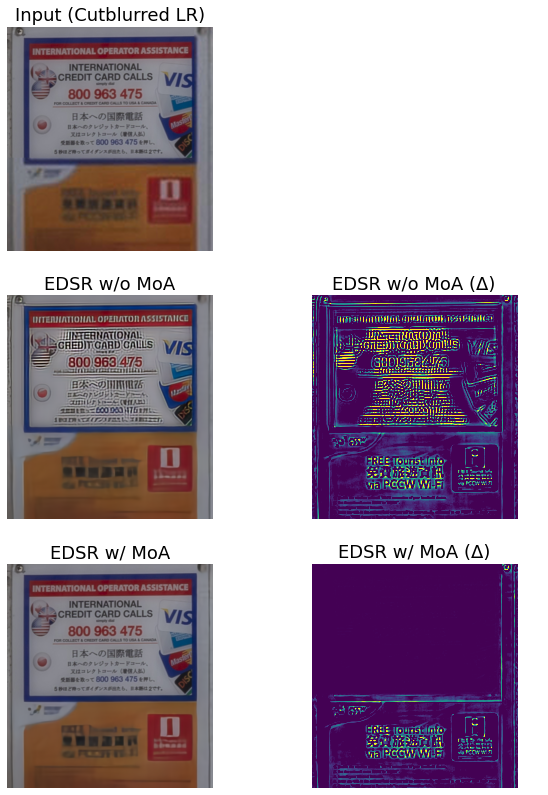

In [9]:
LR_plot = tensor2im(LR_tensor)[900:1500, 100:650] / 255
HR_plot = HR[900:1500, 100:650] / 255
SR_base_plot = SR_base[900:1500, 100:650] / 255
SR_moa_plot = SR_moa[900:1500, 100:650] / 255

diff_SR_base = (HR_plot-SR_base_plot).mean(2) * 10
diff_SR_moa = (HR_plot-SR_moa_plot).mean(2) * 10

f, axarr = plt.subplots(3, 2, figsize=(10, 14))
axarr[0, 0].imshow(LR_plot)
axarr[0, 0].set_title("Input (Cutblurred LR)", fontsize=18)
axarr[0, 0].axis("off")
 
axarr[0, 1].axis("off")
 
axarr[1, 0].imshow(SR_base_plot)
axarr[1, 0].set_title("EDSR w/o MoA", fontsize=18)
axarr[1, 0].axis("off")
 
axarr[1, 1].imshow(diff_SR_base, vmin=0, vmax=1, cmap="viridis")
axarr[1, 1].set_title("EDSR w/o MoA (Δ)", fontsize=18)
axarr[1, 1].axis("off")

axarr[2, 0].imshow(SR_moa_plot)
axarr[2, 0].set_title("EDSR w/ MoA", fontsize=18)
axarr[2, 0].axis("off")
 
axarr[2, 1].imshow(diff_SR_moa, vmin=0, vmax=1, cmap="viridis")
axarr[2, 1].set_title("EDSR w/ MoA (Δ)", fontsize=18)
axarr[2, 1].axis("off")

plt.show()

실습, 샘플이미지 폴더 경로 설정

In [13]:
import os
import glob

workspace_path = '/gdrive/My Drive/Colab Notebooks/CV_과제7'  # 실습파일 저장 경로 설정
cutblur_path = os.path.join(workspace_path, 'CutBlur')  # CutBlur 데이터 폴더 경로 설정
img_list = glob.glob(os.path.join(cutblur_path, 'samples/HR/*.png'))  # HR 샘플이미지 목록 추출

샘플이미지 순서 섞기

In [16]:
import random

random.seed(0)
random.shuffle(img_list)
img_list[:10]

['/gdrive/My Drive/Colab Notebooks/CV_과제7/CutBlur/samples/HR/86.png',
 '/gdrive/My Drive/Colab Notebooks/CV_과제7/CutBlur/samples/HR/93.png',
 '/gdrive/My Drive/Colab Notebooks/CV_과제7/CutBlur/samples/HR/73.png',
 '/gdrive/My Drive/Colab Notebooks/CV_과제7/CutBlur/samples/HR/16.png',
 '/gdrive/My Drive/Colab Notebooks/CV_과제7/CutBlur/samples/HR/78.png',
 '/gdrive/My Drive/Colab Notebooks/CV_과제7/CutBlur/samples/HR/79.png',
 '/gdrive/My Drive/Colab Notebooks/CV_과제7/CutBlur/samples/HR/14.png',
 '/gdrive/My Drive/Colab Notebooks/CV_과제7/CutBlur/samples/HR/28.png',
 '/gdrive/My Drive/Colab Notebooks/CV_과제7/CutBlur/samples/HR/46.png',
 '/gdrive/My Drive/Colab Notebooks/CV_과제7/CutBlur/samples/HR/1.png']

샘플이미지 10개에 대한 super-resolution 수행

In [15]:
import tqdm
from skimage.transform import resize

path_moa = os.path.join(cutblur_path, "pretrained/RealSR_EDSR_X4_moa.pt")
state_moa = torch.load(path_moa, map_location=lambda storage, loc: storage) # 학습된 모델 불러오기
net_moa.load_state_dict(state_moa)  # 학습된 모델 반영
net_moa.eval()  # 모델 검증모드

Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

for path_image in tqdm.tqdm(img_list[:10], desc="Super-resolution"):

    HR = io.imread(path_image)  # HR 이미지
    LR = resize(HR, (HR.shape[0] // 4, HR.shape[1] // 4), anti_aliasing=True)  # 1/4배 downsampling
    LR = resize(LR, (HR.shape[0], HR.shape[1]), anti_aliasing=True) * 255  # 4배 upsampling
    LR_tensor = im2tensor(LR).unsqueeze(0).to(dev)  # LR 이미지 텐서 생성

    with torch.no_grad():
        SR_moa = tensor2im(net_moa(LR_tensor))  # Super-resolution(SR) 이미지 생성

        HR_plot = HR / 255
        LR_plot = LR / 255
        SR_moa_plot = SR_moa / 255

        diff_SR_moa = (HR_plot-SR_moa_plot).mean(2) * 10  # HR과 SR 이미지 간의 차이값 x 10배

        f, axarr = plt.subplots(2, 2, figsize=(10, 10))
        axarr[0, 0].imshow(HR_plot)  # HR 이미지 출력
        axarr[0, 0].set_title("Ground-truth(HR)", fontsize=18)
        axarr[0, 0].axis("off")

        axarr[0, 1].imshow(LR_plot)  # LR 이미지 출력
        axarr[0, 1].set_title("Input(LR)", fontsize=18)
        axarr[0, 1].axis("off")

        axarr[1, 0].imshow(SR_moa_plot)  # Super-resolution(SR) 이미지 출력
        axarr[1, 0].set_title("EDSR w/ MoA", fontsize=18)
        axarr[1, 0].axis("off")
        
        axarr[1, 1].imshow(diff_SR_moa, vmin=0, vmax=1, cmap="viridis")  # HR과 SR 이미지 간의 차이값 출력
        axarr[1, 1].set_title("EDSR w/ MoA (Δ)", fontsize=18)
        axarr[1, 1].axis("off")

        plt.show()

Output hidden; open in https://colab.research.google.com to view.

# 실습과제

## Kaggle 에서 open dataset 다운로드 받아서 super-resolution 결과 출력하기
- open dataset 검색: https://www.kaggle.com/datasets
- 1) 데이터셋 선택 (일반적인 자연 이미지 데이터셋 권장)
- 2) 데이터셋에 포함된 이미지가 너무 많다면 랜덤하게 10장만 선별하기
- 3) EDSR with CutBlur 모델로 super-resolution 결과 출력하기(예제 코드 수정)
- 4) Super-resolution 결과 분석하기
* 유의사항: 데이터셋을 코랩에 업로드한 이후에 구글 드라이브 마운트하기 (파일 업로드 이후에 마운트해야 파일 접근 가능)

실습문제 1. Super-resolution 결과 출력(예제 코드 수정하여 출력결과 보이기)

In [18]:
import tqdm
from skimage.transform import resize

path_moa = os.path.join(cutblur_path, "pretrained/RealSR_EDSR_X4_moa.pt")
state_moa = torch.load(path_moa, map_location=lambda storage, loc: storage) # 학습된 모델 불러오기
net_moa.load_state_dict(state_moa)  # 학습된 모델 반영
net_moa.eval()  # 모델 검증모드

Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

for path_image in tqdm.tqdm(img_list[50:61], desc="Super-resolution"):

    HR = io.imread(path_image)  # HR 이미지
    LR = resize(HR, (HR.shape[0] // 4, HR.shape[1] // 4), anti_aliasing=True)  # 1/4배 downsampling
    LR = resize(LR, (HR.shape[0], HR.shape[1]), anti_aliasing=True) * 255  # 4배 upsampling
    LR_tensor = im2tensor(LR).unsqueeze(0).to(dev)  # LR 이미지 텐서 생성

    with torch.no_grad():
        SR_moa = tensor2im(net_moa(LR_tensor))  # Super-resolution(SR) 이미지 생성

        HR_plot = HR / 255
        LR_plot = LR / 255
        SR_moa_plot = SR_moa / 255

        diff_SR_moa = (HR_plot-SR_moa_plot).mean(2) * 10  # HR과 SR 이미지 간의 차이값 x 10배

        f, axarr = plt.subplots(2, 2, figsize=(10, 10))
        axarr[0, 0].imshow(HR_plot)  # HR 이미지 출력
        axarr[0, 0].set_title("Ground-truth(HR)", fontsize=18)
        axarr[0, 0].axis("off")

        axarr[0, 1].imshow(LR_plot)  # LR 이미지 출력
        axarr[0, 1].set_title("Input(LR)", fontsize=18)
        axarr[0, 1].axis("off")

        axarr[1, 0].imshow(SR_moa_plot)  # Super-resolution(SR) 이미지 출력
        axarr[1, 0].set_title("EDSR w/ MoA", fontsize=18)
        axarr[1, 0].axis("off")
        
        axarr[1, 1].imshow(diff_SR_moa, vmin=0, vmax=1, cmap="viridis")  # HR과 SR 이미지 간의 차이값 출력
        axarr[1, 1].set_title("EDSR w/ MoA (Δ)", fontsize=18)
        axarr[1, 1].axis("off")

        plt.show()

Output hidden; open in https://colab.research.google.com to view.

실습문제 2. 선택한 데이터셋 정보(이름, 다운로드 링크): 

Super Image Resolution
Image Super Resolution (x4) Using a Generative Adversarial Network

https://www.kaggle.com/datasets/akhileshdkapse/super-image-resolution?resource=download

실습문제 3. Super-resolution 결과 분석(어떤 경우에 super-resolution 결과가 우수/미흡한지?): 

이미지가 단순하고 색이 적게 사용되었을 때,눈으로 인식했을 때 super resolution 결과가 우수하다고 느껴졌다. 복잡한 무늬나 디테일한 부분은 잘 복원하지 못했다.